# Bee-wildered: ChatGPT-4o-mini struggles with the NYT Spelling Bee

I have been playing the NYT games for a few years now (Letterboxed, Spelling Bee, Connections, Wordle, etc.). I started off being horrible, but over time, I've gotten familiar with the different solves.

My favourite part of any game is playing it with someone - seeing how they do, teasing losses and celebrating wins. I was curious to see how good of a player ChatGPT-4o-mini would be.
I decided to test its performance at the Spelling Bee.
I've seen some people prompt engineer to get ChatGPT to solve the Wordle (some have tried with agents too).

For this project, I focused exclusively on the NYT Spelling Bee. More specifically, on one key aspect of the Spelling Bee -- the pangram i.e. the word(s) that gives you the most points.

How to Play Spelling Bee - (see image below)

1. 7 letters are provided, with one fixed letter in the center.
2. The player is supposed to make as many 4 or more letter words.
3. Each word must contain the center letter.
4. Letters can be repeated.
5. A pangram is a word that uses all 7 letters at least once.
6. There are one or more **pangrams** in each game. For the image below, there is only one pangram - ***inexact***

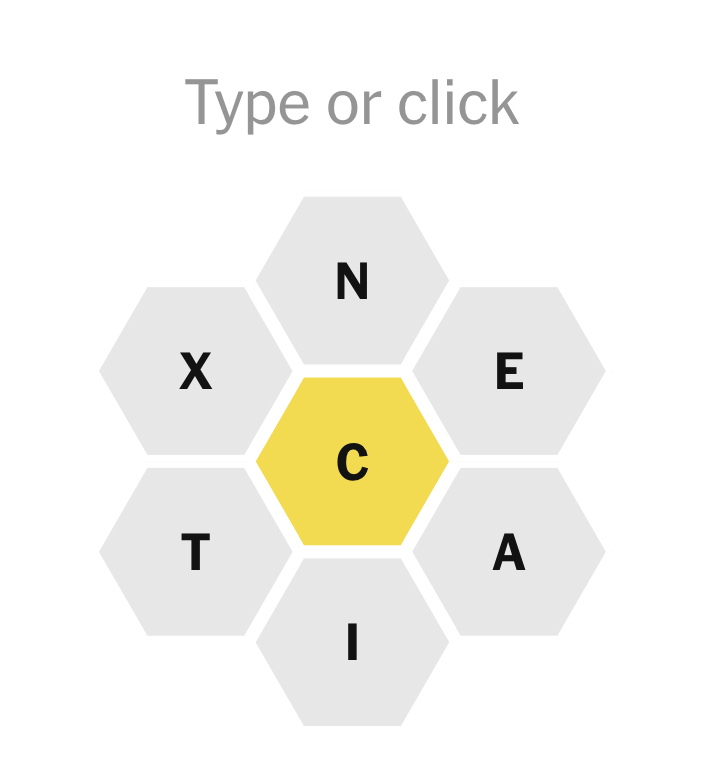

Install required packages

In [1]:
!pip install nltk
!pip install wordfreq
!pip install --upgrade openai

### Loading Libraries

In [2]:
from wordfreq import word_frequency
from nltk.corpus import words
from collections import defaultdict
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os, json

from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.metrics.distance import edit_distance
from collections import Counter

import re
import ast

from openai import OpenAI

### Dataset Creation

Filtering words to get pangrams

In [3]:
# Ensure nltk's words corpus is available (for the list of words to check against)
nltk.download('words')

def generate_spelling_bee_data(frequency_threshold=0.000001):
    """Generates Spelling Bee data efficiently.

    Args:
        frequency_threshold (float): Minimum word frequency to include a word.

    Returns:
        list: List of dictionaries containing distinct letters, pangrams, and their count.
    """
    # Precompute word frequencies for only valid words
    word_list = [word.lower() for word in words.words() if len(word) >= 7]
    word_frequencies = {word: word_frequency(word, 'en') for word in word_list}

    # Group words by distinct letters
    grouped_words = defaultdict(list)
    for word in word_list:
        distinct_letters = ''.join(sorted(set(word)))

        # NYT Spelling Bee is only 7 distinct letters - ofcourse, we could do more or less, if we want.

        if len(distinct_letters) == 7:  # Ensure 7 distinct letters
            grouped_words[distinct_letters].append(word)

    # Filter words based on frequency threshold and create final dataset
    spelling_bee_data = [
        {
            "distinct_letters": key,
            "pangrams": list(set([word for word in val if word_frequencies.get(word, 0) > frequency_threshold])),
            "num_pangrams": len(list(set([word for word in val if word_frequencies.get(word, 0) > frequency_threshold]))),
        }
        for key, val in grouped_words.items()
    ]

    # Remove entries with no pangrams
    spelling_bee_data = [entry for entry in spelling_bee_data if entry["num_pangrams"] > 0]

    return spelling_bee_data

# Generate Spelling Bee data
spelling_bee_data = generate_spelling_bee_data()
print(f"Total groups: {len(spelling_bee_data)}")
# spelling_bee_data

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Total groups: 2410


Creating a dataset class with some helper functions

In [4]:
class PangramDataset:
    def __init__(self, data):
        self.data = data

    def get_random_entries(self, n):
        """Gets N random entries from the dataset.

        Args:
            n (int): Number of random entries to retrieve.

        Returns:
            list: List of random entries from the dataset.
        """
        if n > len(self.data):
            raise ValueError("Requested more entries than available in the dataset.")
        return random.sample(self.data, n)

    def __iter__(self):
        """Allows iteration over the dataset entries."""
        return iter(self.data)

    def __len__(self):
        """Returns the number of entries in the dataset."""
        return len(self.data)

    def __getitem__(self, index):
        """Allows access to a specific entry by index."""
        return self.data[index]

    def is_pangram(self, word):
        """Checks if the given word is a pangram in the dataset."""
        for entry in self.data:
            if word in entry['pangrams']:
                return True
        return False

    def validate_dataset_integrity(self):
        """Checks if 'num_pangrams' matches the actual count of pangrams in each entry."""
        errors = []
        for entry in self.data:
            if len(entry['pangrams']) != entry['num_pangrams']:
                errors.append(entry)
        return errors

    def get_distinct_letter_combinations(self):
        """Returns all unique 'distinct_letters' combinations in the dataset."""
        return list(set(entry['distinct_letters'] for entry in self.data))

    def validate_dataset_size(self):
        return len(self.get_distinct_letter_combinations()) == len(self.data)

    def search_by_letters(self, letters):
        """Searches for dataset entry where 'distinct_letters' matches the given letters."""
        # Normalize the input letters (sort them for comparison)
        sorted_letters = ''.join(sorted(letters))
        for entry in self.data:
            if ''.join(sorted(entry['distinct_letters'])) == sorted_letters:
                return entry
        return None

    def find_other_pangrams(self, word):
        """Finds all other pangrams in the dataset for a given word."""
        for entry in self.data:
            if word in entry['pangrams']:
                # Return all pangrams except the given word
                return [pangram for pangram in entry['pangrams'] if pangram != word]
        return []

    def get_pangrams_by_number(self, num):
        """Finds dataset entries with a specific number of pangrams."""
        return [entry for entry in self.data if entry['num_pangrams'] == num]

    def filter_by_letters(self, letters):
        """Filters dataset entries where 'distinct_letters' contains the given subset of letters."""
        subset = set(letters)
        return [entry for entry in self.data if subset.issubset(set(entry['distinct_letters']))]

    def get_max_pangrams(self):
        """Finds the dataset entry with the maximum number of pangrams."""
        return max(self.data, key=lambda entry: entry['num_pangrams'])

Number of entries with pangrams not equal to count:  0
Are all the entries distinct:  True
Search Result: {'distinct_letters': 'aeinort', 'pangrams': ['orientation', 'iteration', 'anterior'], 'num_pangrams': 3}
Other Pangrams: ['orientation', 'anterior']


In [ ]:
dataset = PangramDataset(spelling_bee_data)

# Checking if number of pangrams is equal to actual pangrams
print("Number of entries with pangrams not equal to count: ", len(dataset.validate_dataset_integrity()))

# Checking if all distinct letter entries are unique
print("Are all the entries distinct: ", dataset.validate_dataset_size())

# Search by letters
search_result = dataset.search_by_letters('aeitnor')
print("Search Result:", search_result)

# Find other pangrams
other_pangrams = dataset.find_other_pangrams('iteration')
print("Other Pangrams:", other_pangrams)

In [6]:
# Finding all entries with 'ing' in them
ing_filter = dataset.filter_by_letters('ing')
print("Entries with 'ing': ", ing_filter)

# Get the entry(s) with most no. of pangrams
print("Max Pangrams: ", dataset.get_max_pangrams())

# Get entries which have n no. of pangrams
print("Entries with 5 pangrams each: ", dataset.get_pangrams_by_number(5))

Entries with 'ing':  [{'distinct_letters': 'adegiln', 'pangrams': ['leading', 'dealing'], 'num_pangrams': 2}, {'distinct_letters': 'adgijno', 'pangrams': ['adjoining'], 'num_pangrams': 1}, {'distinct_letters': 'adgimnr', 'pangrams': ['admiring'], 'num_pangrams': 1}, {'distinct_letters': 'acdginv', 'pangrams': ['advancing'], 'num_pangrams': 1}, {'distinct_letters': 'aceginr', 'pangrams': ['carnegie'], 'num_pangrams': 1}, {'distinct_letters': 'aegimnt', 'pangrams': ['teaming'], 'num_pangrams': 1}, {'distinct_letters': 'adginst', 'pangrams': ['standing'], 'num_pangrams': 1}, {'distinct_letters': 'aegilnt', 'pangrams': ['genitalia', 'genital'], 'num_pangrams': 2}, {'distinct_letters': 'aegintv', 'pangrams': ['negative', 'vintage', 'navigate'], 'num_pangrams': 3}, {'distinct_letters': 'aginrtv', 'pangrams': ['aggravating'], 'num_pangrams': 1}, {'distinct_letters': 'aeginrs', 'pangrams': ['earnings'], 'num_pangrams': 1}, {'distinct_letters': 'aegilns', 'pangrams': ['leasing', 'sealing'], 'nu

Basic Visualizations for the dataset

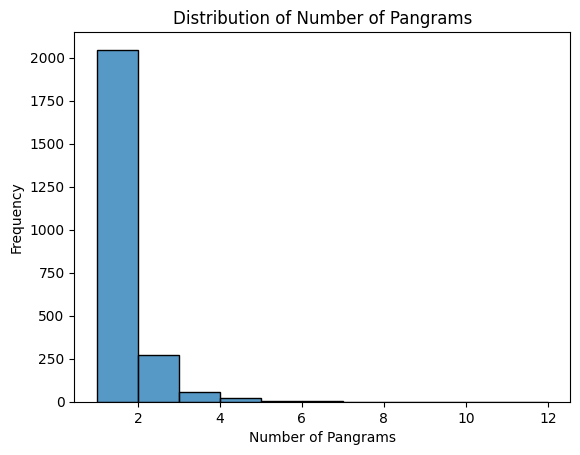

In [7]:
def plot_num_pangrams_histogram(dataset):
    """
    Plots a histogram of the distribution of the number of pangrams in the dataset.

    Args:
        dataset (PangramDataset): The dataset containing the pangram data.
    """

    # Extract the number of pangrams
    num_pangrams = [entry['num_pangrams'] for entry in dataset.data]

    # Plot the histogram
    sns.histplot(num_pangrams, bins=range(min(num_pangrams), max(num_pangrams) + 2), kde=False)

    # Add labels and title
    plt.xlabel('Number of Pangrams')
    plt.ylabel('Frequency')
    plt.title('Distribution of Number of Pangrams')

    # Show the plot
    plt.show()

plot_num_pangrams_histogram(dataset)

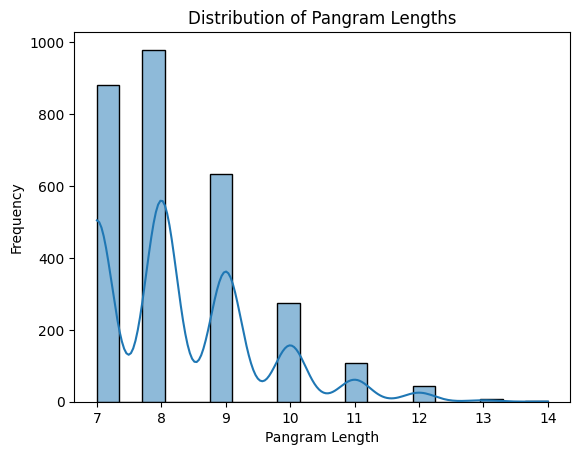

In [8]:
def plot_pangram_lengths(dataset):
    """Plots a histogram of pangram lengths."""

    pangram_lengths = [len(pangram) for entry in dataset.data for pangram in entry['pangrams']]
    sns.histplot(pangram_lengths, kde=True, bins=20)
    plt.xlabel('Pangram Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Pangram Lengths')
    plt.show()

plot_pangram_lengths(dataset)

### Sample Evaluation

Post-processing and evaluation functions

In [9]:
def extract_list_from_string(input_str):
    """
    Extract a list from a string containing a Python-style list within square brackets.

    Parameters
    ----------
    input_str : str
        The input string potentially containing a list (e.g., "[1, 2, 3]").

    Returns
    -------
    list
        The extracted list if found and valid, otherwise an empty list.

    Example
    -------
    >>> extract_list_from_string("The numbers are [1, 2, 3].")
    [1, 2, 3]

    >>> extract_list_from_string("No list here.")
    []

    >>> extract_list_from_string("Invalid list [1, 2,].")
    []
    """

    # Use regex to extract the part within square brackets
    match = re.search(r'\[[^\]]*\]', input_str)

    if match:
        bracketed_str = match.group(0)  # Extract the entire string with brackets

        # Use ast.literal_eval directly on the extracted part
        try:
            return ast.literal_eval(bracketed_str)
        except (ValueError, SyntaxError):
            return []  # Return an empty list if there's an error in evaluation
    else:
        return []

def metrics(output, label):
    """
    Calculate evaluation metrics for comparing two lists: Exact Match, Precision, Recall, and F1-Score.

    Parameters
    ----------
    output : list
        Predicted output list.
    label : list
        Ground truth list.

    Returns
    -------
    dict
        A dictionary with:
        - "Exact_Match": 1 if `output` matches `label` exactly, else 0.
        - "Precision": True positives / total in `output` (0 if `output` is empty).
        - "Recall": True positives / total in `label` (0 if `label` is empty).
        - "F1-Score": Harmonic mean of Precision and Recall (0 if both are 0).

    Example
    -------
    >>> metrics(["word1", "word2", "word3"], ["word2", "word3", "word4"])
    {'Exact_Match': 0, 'Precision': 0.6667, 'Recall': 0.6667, 'F1-Score': 0.6667}
    """

    exact_match = int(sorted(output) == sorted(label))

    # Convert to sets
    output_set, label_set = set(output), set(label)

    # Precision, Recall, F1
    true_positives = len(output_set & label_set)
    precision = true_positives / len(output) if output else 0
    recall = true_positives / len(label) if label else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0

    return {
        "Exact_Match": exact_match,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

Note: Need an API key to test this on ChatGPT-4o-mini

In [11]:
import openai

# Set your API key
personal_api_key = os.getenv("openai_api_key")

client = OpenAI(
    api_key = personal_api_key
)

In [12]:
system_message = """
You are a helpful assistant that answers questions clearly and concisely.
I need your help trying to find the pangram for the New York Times Spelling Bee.
The Spelling Bee provides 7 letters. A valid pangram is a english word that uses all 7 letters atleast once.
There can be more than one pangram. Proper nouns are not admissible.

All letters given to you will have at least one pangram.

Here's 2 examples:
1. Input: Letters - a,b,c,e,i,n,t
Output: [cabinet]

2. Input: Letters - a,e,i,n,o,r,t
Output: [anterior, iteration, orientation]

If you can't find a valid pangram, return [None].
Otherwise, return the output in format of a list with pangrams separated by a comma.

Do NOT return anything else other than a list.
"""

Function that calls the model and processes the response

In [13]:
def find_pangrams(letters):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": f"Here are the letters - {letters}\nReturn all pangrams."
            }
        ],
        response_format={"type": "text"},
        temperature=1,
        max_tokens=2048
    )
    return extract_list_from_string(response.choices[0].message.content)

Sample evaluation on N random entries

In [16]:
N = 10
sample_eval_data = dataset.get_random_entries(N)

metrics_arr = []

for ix, example in enumerate(sample_eval_data):
    print("Ground Truth Label: ", example['pangrams'])

    letters_input = ','.join([char for char in example['distinct_letters']])

    output = find_pangrams(letters_input)
    print(output)

    results = metrics(output, example['pangrams'])

    metrics_arr.append(results)

    print(" ------------------------- ")

Ground Truth Label:  ['justice']
[]
 ------------------------- 
Ground Truth Label:  ['worship']
['prowship']
 ------------------------- 
Ground Truth Label:  ['onwards']
['sandworm', 'dronawas']
 ------------------------- 
Ground Truth Label:  ['assertive']
['stairver', 'stavers', 'traverse']
 ------------------------- 
Ground Truth Label:  ['pavilion']
[]
 ------------------------- 
Ground Truth Label:  ['believing']
['vigilance']
 ------------------------- 
Ground Truth Label:  ['happiness']
['painches', 'sapience']
 ------------------------- 
Ground Truth Label:  ['calorie']
['coaler', 'recital']
 ------------------------- 
Ground Truth Label:  ['saviour', 'various']
['variours', 'aviso', 'sour', 'uvisor']
 ------------------------- 
Ground Truth Label:  ['solicitor']
[]
 ------------------------- 


Printing out metric info

In [20]:
# Aggregating metrics
aggregated_metrics = {
    'Exact_Match': sum(m['Exact_Match'] for m in metrics_arr) / len(metrics_arr),
    'Precision': sum(m['Precision'] for m in metrics_arr) / len(metrics_arr),
    'Recall': sum(m['Recall'] for m in metrics_arr) / len(metrics_arr),
    'F1-Score': sum(m['F1-Score'] for m in metrics_arr) / len(metrics_arr)
}

print(json.dumps(aggregated_metrics, indent=4))

{
    "Exact_Match": 0.0,
    "Precision": 0.0,
    "Recall": 0.0,
    "F1-Score": 0.0
}


ChatGPT-4o-mini faces significant challenges in generating words from a specific set of letters, particularly when tasked with forming pangrams.

One possible reason could be because of tokenization. I tried giving it letters without separating it with commas, but it struggles to form pangrams from that too.

WWhile ChatGPT-4o-mini excels at understanding and generating words and longer spans of text, it appears to intrinsically struggle with tasks requiring precise reasoning at the level of individual letters. This limitation might stem from its training data or architecture not prioritizing such granular linguistic tasks.

This could be improved with some fine-tuning. Some anecdotal testing with ChatGPT-4o showed that it does get some pangrams correct. Perhaps, o-1 does even better. Further experimentation and benchmarking would help validate these observations and guide improvements.